In this notebook, we explore if performance of graph neural networks can be improved if supplemented with classical [Morgan fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t). For this, we trying this out using Pytorch-geomtric on a [dataset](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#lipo-datasets) related to the prediction of lipophilicity.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import math
import matplotlib.pyplot as plt
from itertools import product
import random
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator, Draw
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import coo_matrix
from torch_geometric.data import Data
from torch_geometric.nn.conv import GCNConv
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.nn.aggr import (
    MultiAggregation, MeanAggregation, StdAggregation, SoftmaxAggregation)
from torch_geometric.loader import DataLoader as DataLoader_pyg
import torch_geometric.transforms as T
from torch_geometric.data import Batch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
import logging
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*The number of training batches*")
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
plt.rcParams["figure.dpi"] = 300
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

n_train = 3000
n_val = 600
n_test = 600
use_edge_attr = False
transforms = T.Compose([T.VirtualNode()])
mfp_size = 256
batch_size = 64

Let's load the dataset and establish a bit of functionality to convert the molecular SMILES strings into graph data & morgan fingerprints, and also let's look at a few molecular structures in the dataset:

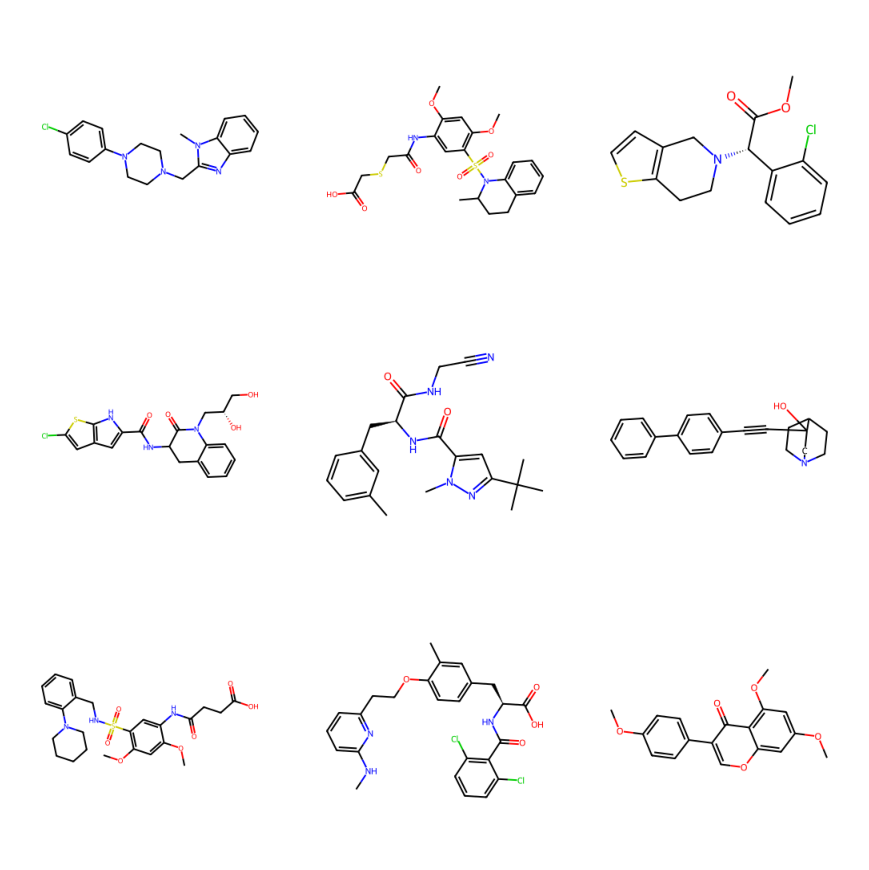

In [2]:
class MoleculeProcessor:
    def __init__(self, atom_types=None, bond_types=None, use_edge_attr=False, 
                 transforms=None):
        if atom_types is None:
            atom_types = []
        self.dic_atoms = {symbol: idx for idx, symbol in enumerate(atom_types)}
        if bond_types is None:
            bond_types = []
        self.dic_bonds = {symbol: idx for idx, symbol in enumerate(bond_types)}
        self.transforms = transforms
        self.use_edge_attr = use_edge_attr
    
    @staticmethod
    def smile_to_mol(smile):
        return Chem.MolFromSmiles(smile)
    
    @staticmethod
    def smiles_to_mfps(smiles, fpSize, radius=2):
        mfp_generator = rdFingerprintGenerator.GetMorganGenerator(
            radius=radius, fpSize=fpSize)
        mfps = np.zeros((len(smiles), fpSize))

        for idx, smile in enumerate(smiles):
            mfp = mfp_generator.GetFingerprint(Chem.MolFromSmiles(smile))
            DataStructs.ConvertToNumpyArray(mfp, mfps[idx, :])
        return mfps
    
    def smile_to_data(self, smile, y=None):
        mol = MoleculeProcessor.smile_to_mol(smile)
        edge_idx, _, n_edges = self.get_edge_idx(mol)
        x = self.get_x(mol)
        edge_attr = None
        if self.use_edge_attr:
            edge_attr = self.get_edge_attr(mol, edge_idx, n_edges)
        
        data = Data(x=x, edge_index=edge_idx, edge_attr=edge_attr, y=y)
        if self.transforms is not None:
            return self.transforms(data)
        return data
        
    def smiles_to_datalist(self, smiles, y=None):
        data = []
        for idx, smile in enumerate(smiles):
            if y is None:
                data.append(self.smile_to_data(smile, None))
            else:
                data.append(
                    self.smile_to_data(smile, torch.tensor(y[idx]).float()))
        return data
        
    def get_x(self, mol):
        x = [self.dic_atoms[atom.GetSymbol()] for atom in mol.GetAtoms()]
        return torch.tensor(x).type(torch.int64)
    
    def get_edge_idx(self, mol):
        adj = coo_matrix(Chem.GetAdjacencyMatrix(mol))
        edge_idx = torch.stack(
            [torch.from_numpy(adj.row).to(torch.long),
             torch.from_numpy(adj.col).to(torch.long)],
            dim=0
            )
        n_nodes = adj.shape[0]
        n_edges = int(np.sum(adj))
        return edge_idx, n_nodes, n_edges
    
    def get_edge_attr(self, mol, edge_idx, n_edges):
        edge_attr = np.zeros((n_edges,), dtype=int)
        for count, (idx1, idx2) in enumerate(zip(edge_idx[0], edge_idx[1])):
            bond_type = str((mol).GetBondBetweenAtoms(
                int(idx1), int(idx2)).GetBondType())
            edge_attr[count] = self.dic_bonds[bond_type] + 1
            
        edge_attr = torch.from_numpy(edge_attr).type(torch.float32)
        return edge_attr

    def _atom_type(self, smile, idx, check_validity):
        try:
            mol = MoleculeProcessor.smile_to_mol(smile)
            atom_types = [str(atom.GetSymbol()) for atom in mol.GetAtoms()]
            if check_validity:
                invalid = [
                    x for x in atom_types if x not in self.dic_atom.keys()]
                if len(invalid) > 0:
                    raise Exception(f"Atoms {invalid} not allowed")
            return atom_types, []
        except:
            return [], [idx]
    
    def get_atom_types(self, smiles, check_validity=False):
        atom_types = set()
        idx_exception = []
        for idx, smile in enumerate(smiles):
            # print(idx, smile)
            atom_types_cur, idx_exception_cur = self._atom_type(
                smile, idx, check_validity)
            atom_types.update(atom_types_cur)
            idx_exception.extend(idx_exception_cur)
        return sorted(atom_types), idx_exception
    
    def get_bond_types(self, smiles):
        bond_types = set()
        idx_exception = []
        for idx, smile in enumerate(smiles):
            try:
                mol = MoleculeProcessor.smile_to_mol(smile)
                bond_types_cur = [
                    str(bond.GetBondType()) for bond in mol.GetBonds()]
                bond_types.update(bond_types_cur)
            except:
                idx_exception.append(idx)
        return sorted(bond_types), idx_exception
    
    def plot(self, smiles, labels=None, n_cols=3, figsize=None):
        cols = len(smiles) if len(smiles) < n_cols else n_cols
        rows = math.ceil(len(smiles) / cols)

        if len(smiles) > 1:
            fig, ax = plt.subplots(rows, cols, figsize=figsize)
        else:
            fig, ax = plt.subplots(figsize=figsize)
        
        for idx0, (idx1, idx2) in enumerate(
                product(range(rows), range(cols))):
            if len(smiles) == 1:
                obj = ax
            elif rows <= 1:
                obj = ax[idx2]
            elif cols <= 1:
                obj = ax[idx1]
            else:
                obj = ax[idx1, idx2]
            
            if idx0 < len(smiles):
                obj.imshow(Draw.MolToImage(self.smile_to_mol(smiles[idx0])))
                if labels is not None:
                    obj.set_title(labels[idx0])
            else:
                try:
                    fig.delaxes(obj)
                except:
                    pass
        if len(smiles) > 1:
            [axi.set_axis_off() for axi in ax.ravel()]
        else:
            ax.set_axis_off()
        plt.tight_layout()
        plt.show()

col_mfps = [f"mfp_{str(idx).zfill(4)}" for idx in range(mfp_size)]
df = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv")
df = pd.concat(
    (df,
     pd.DataFrame(MoleculeProcessor.smiles_to_mfps(
         df["smiles"], fpSize=mfp_size), columns=col_mfps)
     ),
     axis=1
    )

processor = MoleculeProcessor()
atom_types, _ = processor.get_atom_types(df["smiles"].tolist())
bond_types, _ = processor.get_bond_types(df["smiles"].tolist())
processor = MoleculeProcessor(
    atom_types, bond_types, use_edge_attr, transforms)

processor.plot(df["smiles"].values.tolist()[0:9], figsize=(3, 3))

Let's split the dataset into train, validation, and test set. This is here done at random. Random splits are quite generally not advisable for chemical datasets because they ignore chemical similarity - But anyway. Next, we create some data loader, both for the scenario of just feed graph data to our GNN and graph data + Morgan fingerprints

In [3]:
df_train = df.sample(n=n_train, random_state=seed)
df = df[~df.index.isin(df_train.index)].reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

df_val = df.sample(n=n_val, random_state=seed)
df_test = df[~df.index.isin(df_val.index)].reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# Without exogenouse features
ds_train0 = processor.smiles_to_datalist(
    df_train["smiles"].tolist(), df_train["exp"].values)
ds_val0 = processor.smiles_to_datalist(
    df_val["smiles"].tolist(), df_val["exp"].values)
ds_test0 = processor.smiles_to_datalist(
    df_test["smiles"].tolist(), df_test["exp"].values)

loader_train0 = DataLoader_pyg(
    ds_train0, batch_size=batch_size, shuffle=True)
loader_val0 = DataLoader_pyg(
    ds_val0, batch_size=batch_size, shuffle=False)
loader_test0 = DataLoader_pyg(
    ds_test0, batch_size=batch_size, shuffle=False)


# With exogenouse features
class CustomDatasetwExFeats(Dataset):
    def __init__(self, df, atom_types, bond_types, cols_ex, 
                 use_edge_attr=False, transforms=None):
        self.df = df
        self.processor = MoleculeProcessor(
            atom_types=atom_types,
            bond_types=bond_types,
            use_edge_attr=use_edge_attr,
            transforms=transforms
            )
        self.cols_ex = cols_ex
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        smile = self.df.loc[idx, ["smiles"]].values[0]
        graph_data = self.processor.smile_to_data(smile)
        
        ex = torch.from_numpy(self.df.loc[idx, self.cols_ex].values.astype(np.float32))

        y = torch.from_numpy(
            self.df.loc[idx, ["exp"]].values.astype(np.float32))
        return graph_data, ex, y


def custom_collate(data_list):
    graph_data = Batch.from_data_list([data[0] for data in data_list])
    ex = torch.stack([data[1] for data in data_list])
    y = torch.stack([data[2] for data in data_list])
    return graph_data, ex, y[:, 0] 


ds_train1 = CustomDatasetwExFeats(
    df_train, atom_types, bond_types, transforms=transforms, cols_ex=col_mfps)
ds_val1 = CustomDatasetwExFeats(
    df_val, atom_types, bond_types, transforms=transforms, cols_ex=col_mfps)
ds_test1 = CustomDatasetwExFeats(
    df_test, atom_types, bond_types, transforms=transforms, cols_ex=col_mfps)

loader_train1 = DataLoader(
    ds_train1, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
loader_val1 = DataLoader(
    ds_val1, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
loader_test1 = DataLoader(
    ds_test1, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

Let's define our models:

In [4]:
class MLP(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        modules = []
        for i in range(len(neurons) - 1):
            modules.append(nn.Linear(neurons[i], neurons[i+1]))
            if i != len(neurons) - 2:
                modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*modules)
        self.apply(self._initialize)
        
    def forward(self, x):
        return self.mlp(x)
    
    def _initialize(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, residual):
        super().__init__()
        self.gcn = GCNConv(in_channels, out_channels, improved=True)
        self.norm = GraphNorm(out_channels)
        self.residual = residual
        self.apply(self._initialize)
    
    def forward(self, x, edge_index, edge_weight):
        x_in = x 
        x = self.gcn(F.relu(x), edge_index, edge_weight)
        x = self.norm(x)
        if self.residual:
            x = x + x_in
        return x
    
    def _initialize(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


class GNNEncoder(nn.Module):
    def __init__(self, depth, graph_channels, embeddings_dim, embeddings_n):
        super().__init__()
        self.embed = nn.Embedding(embeddings_n, embeddings_dim)
        self.gnn = nn.ModuleList(
            [GCNLayer(embeddings_dim, graph_channels, False)] +
            [GCNLayer(graph_channels, graph_channels, True)
             for _ in range(depth - 1)]
            )
        self.agg = MultiAggregation(
            [
                MeanAggregation(), 
                StdAggregation(), 
                SoftmaxAggregation(t=0.1, learn=True)
                ]
            )
    
    def forward(self, batch):
        x = self.embed(batch.x)
        
        for gnn_layer in self.gnn:
            x = gnn_layer(x, batch.edge_index, batch.edge_attr)

        x = self.agg(x, batch.batch)
        return x
    
                
class GNN(nn.Module):
    def __init__(
        self, depth, graph_channels, embeddings_dim, embeddings_n, dropout, 
        mlp_factors, n_feat_out, n_ex_feats=0):
        super().__init__()
        self.encoder = GNNEncoder(
            depth, graph_channels, embeddings_dim, embeddings_n)
        mlp_neurons = [(graph_channels * f) + n_ex_feats 
                       for f in mlp_factors] + [n_feat_out]
        self.dropout = dropout
        self.mlp = MLP(mlp_neurons)
        
    def forward(self, graph_data, ex_feats=None):
        x = self.encoder(graph_data)
        
        if ex_feats is not None:
            x = torch.cat([x, ex_feats], dim=-1)
        
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)[:, 0]
        return x

    def _load_gnn_encoder(self, fp):
        self.encoder.load_state_dict(torch.load(fp, weights_only=False))
        print("Loaded pretrained GNN encoder")
        
    def _freeze_gnn_encoder(self):
        for p in self.encoder.parameters():
            p.requires_grad = False
        print("Freezing GNN encoder")
    
    def _unfreeze_gnn_encoder(self):
        for p in self.encoder.parameters():
            p.requires_grad = True
        print("Unfreezing GNN encoder")
        

class GNNModule(pl.LightningModule):
    def __init__(self, depth, graph_channels, embeddings_dim, embeddings_n, 
                 dropout, mlp_factors, n_feat_out, n_ex_feats, batch_size, 
                 criterion, lr_init, T_0, T_mult, eta_min):
        super().__init__()
        self.gnn = GNN(
            depth, graph_channels, embeddings_dim, embeddings_n, dropout, 
            mlp_factors, n_feat_out, n_ex_feats
            )
        self.n_ex_feats = n_ex_feats
        self.batch_size = batch_size
        self.criterion = nn.L1Loss()
        self.lr_init = lr_init
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min

    def forward(self, graph_data, ex_feats):
        return self.gnn(graph_data, ex_feats)

    def training_step(self, batch, batch_idx):
        if self.n_ex_feats > 0:
            graph_data, ex_feats, y = batch[0], batch[1], batch[2]
            y_pred = self.forward(graph_data, ex_feats)
        else:
            y = batch.y
            y_pred = self.forward(batch, ex_feats=None)
            
        loss = self.criterion(y_pred, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, 
                 prog_bar=True, batch_size=self.batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        if self.n_ex_feats > 0:
            graph_data, ex_feats, y = batch[0], batch[1], batch[2]
            y_pred = self.forward(graph_data, ex_feats)
        else:
            y = batch.y
            y_pred = self.forward(batch, ex_feats=None)
            
        loss = self.criterion(y_pred, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, 
                 prog_bar=True, batch_size=self.batch_size)
        return loss
    
    @torch.no_grad()
    def predict_step(self, batch, batch_idx):
        self.gnn.eval()
        if self.n_ex_feats > 0:
            graph_data, ex_feats = batch[0], batch[1]
            y_pred = self.forward(graph_data, ex_feats)
        else:
            y_pred = self.forward(batch, ex_feats=None)
        return y_pred

    def configure_optimizers(self):
        self.opt = torch.optim.Adam(self.parameters(), lr=self.lr_init)
        self.train_scheduler = {
            "scheduler": CosineAnnealingWarmRestarts(
                optimizer=self.opt, T_0=self.T_0, T_mult=self.T_mult, 
                eta_min=self.eta_min),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss"}
        return [self.opt], [self.train_scheduler]        
    

def display_training_progress(trainer, y_lim):
    logs = pd.read_csv(Path(trainer.logger.log_dir + "/metrics.csv"))
    epochs = logs.dropna(subset=["train_loss"])["epoch"]

    fig, ax0 = plt.subplots(figsize=(9, 4))
    l0 = ax0.plot(epochs, logs["train_loss"].dropna(), color="r", 
                  label="Training loss")
    l1 = ax0.plot(epochs, logs["val_loss"].dropna(), color="b", 
                  label="Validation loss")
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Loss")
    ax0.set_xlim(0, len(epochs)-1)
        
    ax1 = ax0.twinx() 
    l2 = ax1.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed", 
        label="Learning rate")
    ax1.set_ylabel("Learning rate")
    ax1.set_yscale("log")
    ax0.set_ylim(y_lim[0], y_lim[1])
    ax0.legend(l0+l1+l2, [l.get_label() for l in l0+l1+l2], loc="lower center", 
               bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
    plt.tight_layout()
    plt.show()
    return fig

A few hyperparameters:

In [5]:
kwargs_gnn0 = {
    "depth": 12, 
    "graph_channels": 256,
    "embeddings_n": len(atom_types), 
    "embeddings_dim": int(len(atom_types)**0.5), 
    "dropout": 0.3, 
    "mlp_factors": [3, 6, 3], 
    "n_feat_out": 1,
    "n_ex_feats": 0
    }

kwargs_train = {
    "batch_size": batch_size,
    "criterion": nn.L1Loss(),
    "lr_init": 5e-4,
    "T_0": 20,
    "T_mult": 1,
    "eta_min": 2e-7
    }

kwargs_train_extra = {
    "patience_es": 50,
    "epochs": 200
    }

Let's train our "graph data"-only model:

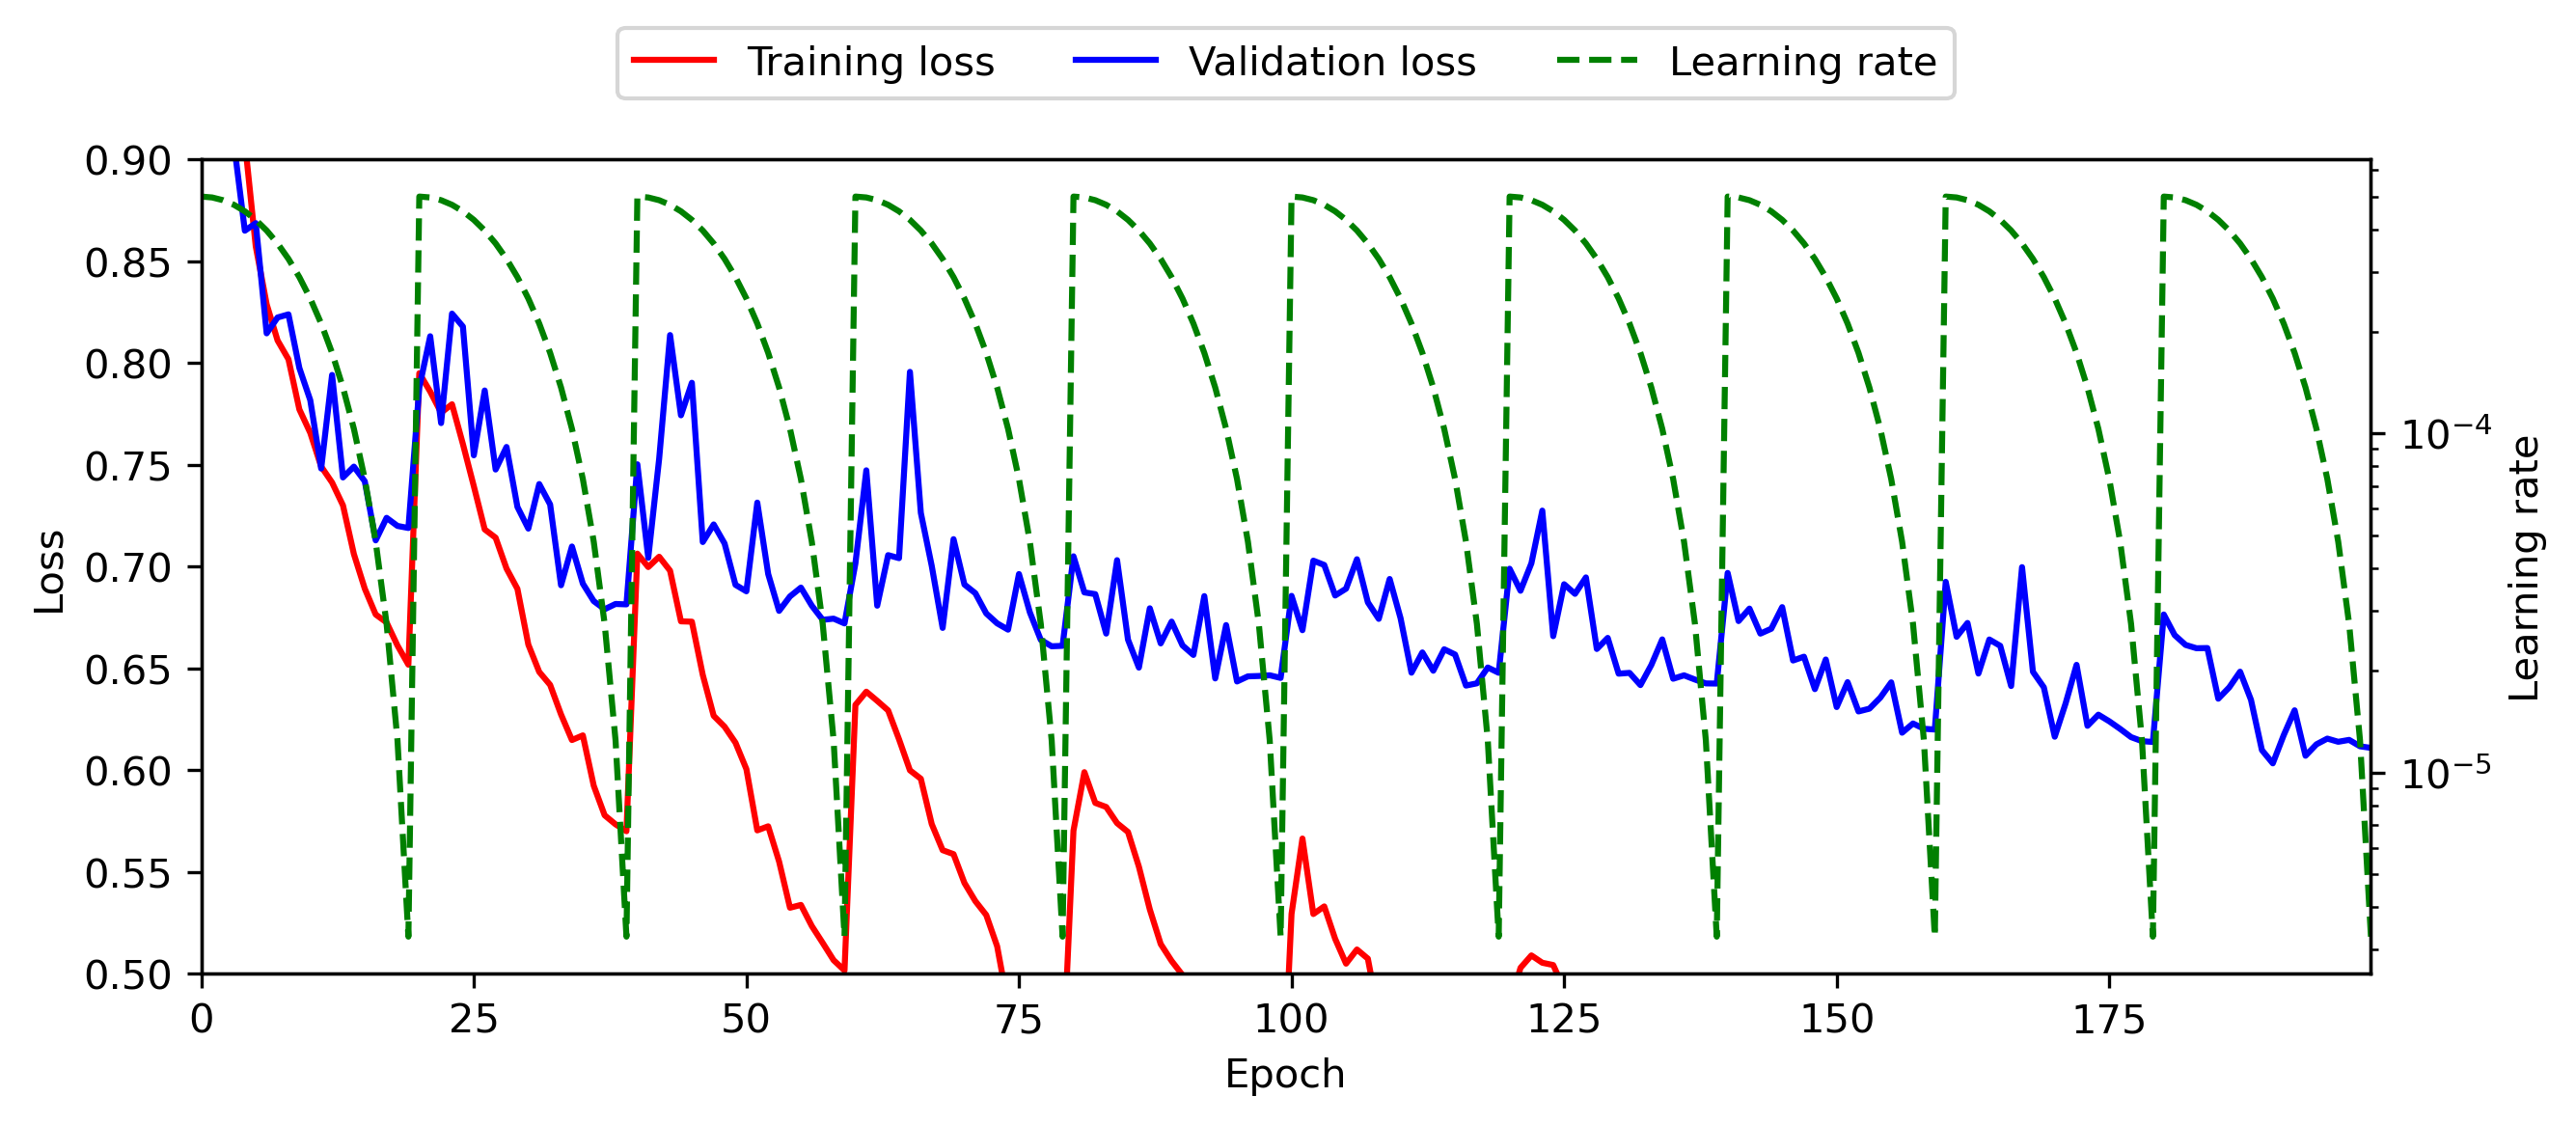

In [6]:
m0 = GNNModule(**(kwargs_gnn0 | kwargs_train))

cb_a0 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b0 = EarlyStopping(
    monitor="val_loss", mode="min", patience=kwargs_train_extra["patience_es"])
cb_c0 = LearningRateMonitor(logging_interval="epoch")
logger0 = CSVLogger(
    save_dir="logs0/", name="model0", flush_logs_every_n_steps=1)

trainer0 = pl.Trainer(
    max_epochs=kwargs_train_extra["epochs"], check_val_every_n_epoch=1,
    callbacks=[cb_a0, cb_b0, cb_c0], logger=logger0, enable_progress_bar=False)
trainer0.fit(
    model=m0, train_dataloaders=loader_train0, val_dataloaders=loader_val0)

fig = display_training_progress(trainer0, [0.5, 0.9])

checkpoint_file = trainer0.checkpoint_callback.best_model_path
m0 = GNNModule.load_from_checkpoint(
    checkpoint_file, **(kwargs_gnn0 | kwargs_train))
    
y_test_pred0 = torch.cat(trainer0.predict(m0, dataloaders=loader_test0))
y_test_true0 = torch.cat([b.y for b in loader_test0])
mae0 = np.mean(
    np.abs(y_test_pred0.detach().numpy() - y_test_true0.detach().numpy()))

Now, our "graph data + Morgan fingerprints" model:

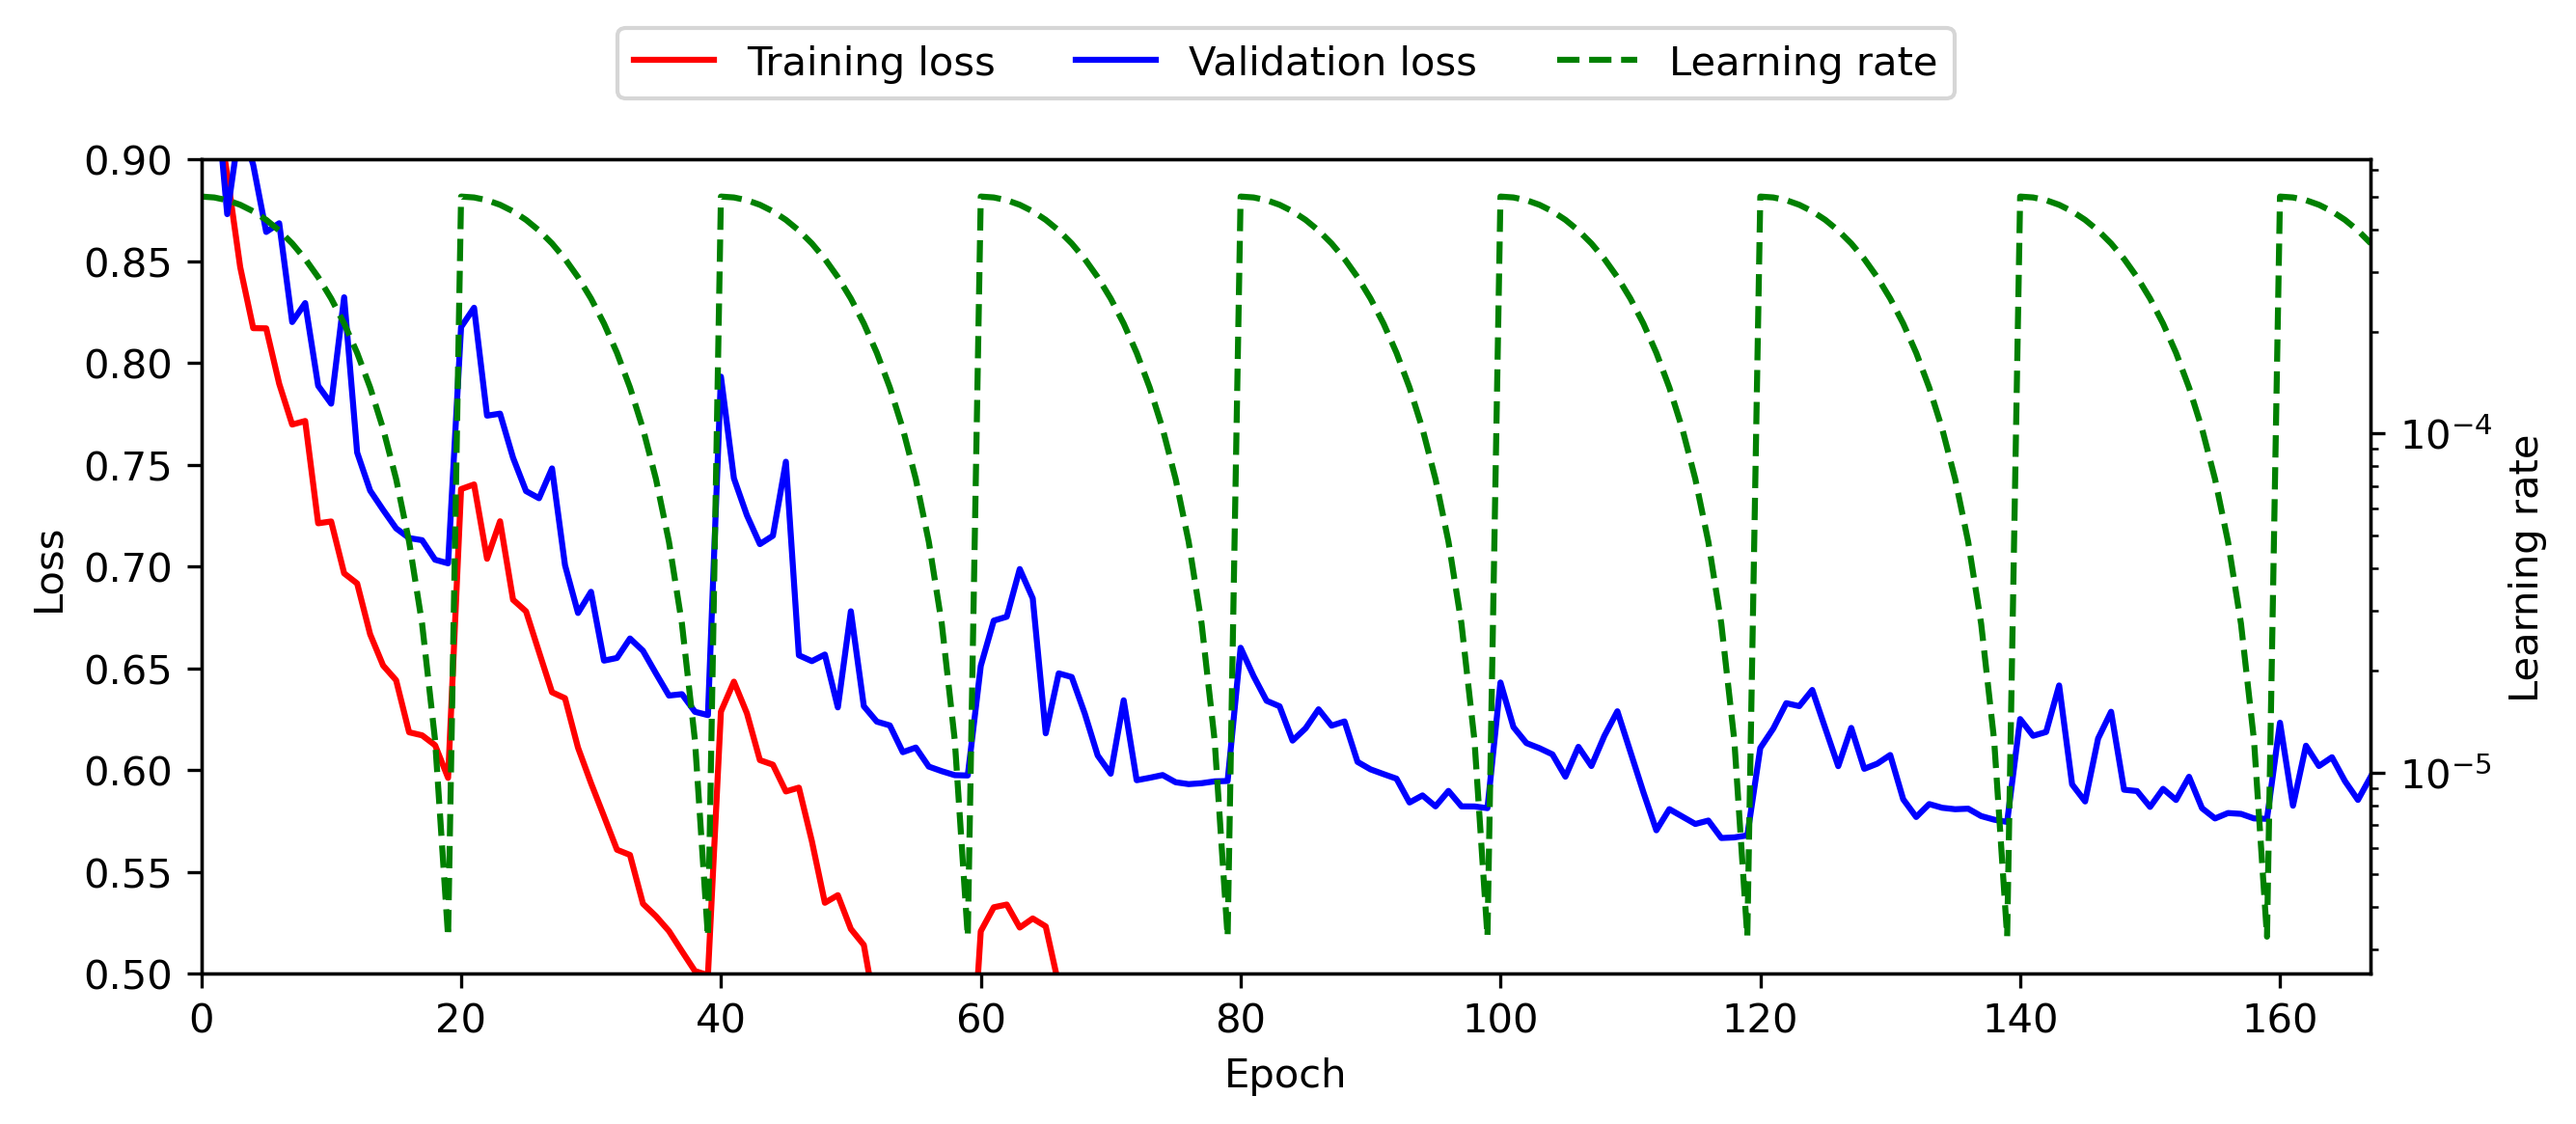

In [7]:
kwargs_gnn1 = deepcopy(kwargs_gnn0)
kwargs_gnn1["n_ex_feats"] = mfp_size      

m1 = GNNModule(**(kwargs_gnn1 | kwargs_train))

cb_a1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b1 = EarlyStopping(
    monitor="val_loss", mode="min", patience=kwargs_train_extra["patience_es"])
cb_c1 = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(
    save_dir="logs1/", name="model1", flush_logs_every_n_steps=1)

trainer1 = pl.Trainer(
    max_epochs=kwargs_train_extra["epochs"], check_val_every_n_epoch=1,
    callbacks=[cb_a1, cb_b1, cb_c1], logger=logger1, enable_progress_bar=False)
trainer1.fit(
    model=m1, train_dataloaders=loader_train1, val_dataloaders=loader_val1)

fig = display_training_progress(trainer1, [0.5, 0.9])

checkpoint_file = trainer1.checkpoint_callback.best_model_path
m1 = GNNModule.load_from_checkpoint(
    checkpoint_file, **(kwargs_gnn1 | kwargs_train))
    
y_test_pred1 = torch.cat(trainer1.predict(m1, dataloaders=loader_test1))
y_test_true1 = torch.cat([b[2] for b in loader_test1])

mae1 = np.mean(
    np.abs(y_test_pred1.detach().numpy() - y_test_true1.detach().numpy()))

And compare results. The "graph data + Morgan fingerprints" models performs slightly better:

In [8]:
print(f"'MAE of graph data only' model: {mae0:.3f}")
print(f"'MAE of graph data + Morgan fingerprints' model: {mae1:.3f}")

'MAE of graph data only' model: 0.565
'MAE of graph data + Morgan fingerprints' model: 0.511
